In [ ]:
# ==========================================
# SETUP BLOCK 
# ==========================================

import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# ---- Imports from project files ----
sys.path.append(os.path.abspath(".."))
from Helper_funtions import (
    clean_up_subjects,
    calculate_true_false_score,
    calculate_Internet_terms_understanding_score,
    group_internet_understanding
)
from lists import (
    demographic_columns,
    multiple_choice_questions,
    single_choice_questions,
    likert_questions,
    likert_mapping,
    comparison_pairs_by_demo,
    cross_tab_titles_and_colors

)
from answer_categories import question_orders

# ---- General plot style ----
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

# ---- Data loading ----
DATA_FILE = os.path.join("..", "Data", "Fertige Tabelle.xlsx")
df = pd.read_excel(DATA_FILE)
df.columns = df.columns.str.strip()

# Clean up multi-subject columns
for col in ["Most used subjects", "Preferred Subjects", "Least preferred Subjects"]:
    if col in df.columns:
        df = clean_up_subjects(df, col)

# Calculate additional scores
if all(q in df.columns for q in ["True/False_1", "True/False_2"]):
    df = calculate_true_false_score(df)

if any(col.startswith("Internet terms_") for col in df.columns):
    df = calculate_Internet_terms_understanding_score(df)
    df = group_internet_understanding(df)

print("✅ Setup complete – DataFrame loaded and preprocessed")
print(f"Rows: {len(df)}, Columns: {len(df.columns)}")


In [ ]:
# ----- original file with all possible crosstabulations -----

# Imports 
sys.path.append(os.path.abspath(".."))
from Helper_funtions import test_significance_single_choice, test_significance_multiple_choice, calculate_true_false_score


for question in multiple_choice_questions:
    for demo in demographic_columns:
        try:
            print(f"\n Distribution of multiple answers for: {question} grouped by {demo}")

            exploded = (
                df[[demo, question]]
                .dropna()
                .assign(**{question: df[question].str.split(",")})
                .explode(question)
            )

            exploded[question] = exploded[question].str.strip()
            cross = pd.crosstab(exploded[demo], exploded[question], normalize='index') * 100

            # Sort alphabetically or define specific sort order if desired
            cross = cross[sorted(cross.columns)]
            print(cross.round(1).to_string())

            # significance test fo every option
            results = test_significance_multiple_choice(exploded, question, demo)
            for res in results:
                if "Error" in res:
                    print(f"   ❌ Option: {res['Option']} → ERROR: {res['Error']}")
                else:
                    print(f"   → Option: {res['Option']} → p-value: {res['p_value']:.4f} → {res['Significance']}")

        except Exception as e:
            print(f"❌ Failed for {question} x {demo}: {e}")

for question in single_choice_questions:
    print(f"\n Distribution of responses for: {question}")
    
    for demo in demographic_columns:
        print(f"– Grouped by: {demo}")

        try:
            df[question] = df[question].astype(str)
            data = df[[demo, question]].dropna()

            # table in percent
            cross = pd.crosstab(data[demo], data[question], normalize='index') * 100
            
            # use defined order of answers
            if question in question_orders:
                order = question_orders[question]
                for col in order:
                    if col not in cross.columns:
                        cross[col] = 0
                cross = cross[order]
            
            # print table
            print(cross.round(1).to_string())

            # significance test
            p = test_significance_single_choice(df, question, demo)
            significance = "✅ significant" if p < 0.05 else "❌ not significant"
            print(f"   → p-value: {p:.4f} → {significance}")

        except Exception as e:
            print(f"❌ Test failed for {question} x {demo}: {e}")



In [ ]:
# ------- selected cross-tabulations with seperated bar plots ------

for demo, question_list in comparison_pairs_by_demo.items(): 
    for question in question_list:

        try:
            if question in multiple_choice_questions:
                exploded_df = (
                    df[[demo, question]]
                    .dropna()
                    .assign(**{question: df[question].str.split(",")})
                    .explode(question)
                )
                exploded_df[question] = exploded_df[question].str.strip()
                data = exploded_df
            elif question in single_choice_questions:
                data = df[[demo, question]].dropna()
                data = data[data[question].astype(str).str.strip() != ""]
            else:
                continue  # Weder Single noch Multiple

            # Crosstab normalized by row (percentages)
            cross = pd.crosstab(data[demo], data[question], normalize='index') * 100

            # Use predefined order if available
            if question in question_orders:
                order = question_orders[question]
                for col in order:
                    if col not in cross.columns:
                        cross[col] = 0
                cross = cross[order]
            
            # Optional: sort numeric demographic column
            if pd.api.types.is_numeric_dtype(df[demo]):
                cross = cross.sort_index()

            print(f"\n📊 {question} grouped by {demo}")
            print(cross.round(1).to_string())

            # Plot as graph
            plot_df = cross.reset_index().melt(id_vars=demo, var_name="Answer", value_name="Percentage")

            plt.figure(figsize=(10, 6))
            sns.barplot(data=plot_df, x="Answer", y="Percentage", hue=demo)

            plt.title(f"{question} grouped by {demo}")
            plt.xticks(rotation=45, ha="right")
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"❌ Test failed for {question} x {demo}: {e}")


In [ ]:
# ------- selected cross-tabulations with stacked bar plots ------



multiple_choice_demographics = {
    "Preferred Subjects",
    "Least preferred Subjects",
    "Most used subjects",
}

# ---------- Helper: Spalte ggf. split/explode + leere Werte droppen ----------
def prepare_column(df_in, col, is_multi):
    """Return DataFrame with just column 'col' (exploded if multi) and cleaned strings."""
    if is_multi:
        tmp = (
            df_in[[col]]
            .dropna()
            .assign(**{col: df_in[col].str.split(",")})
            .explode(col)
        )
        tmp[col] = tmp[col].astype(str).str.strip()
        tmp = tmp[tmp[col] != ""]
        return tmp
    else:
        tmp = df_in[[col]].dropna()
        tmp[col] = tmp[col].astype(str).str.strip()
        tmp = tmp[tmp[col] != ""]
        return tmp

# ---------- Main loop: stacked 100% bars ----------

for demo, question_list in comparison_pairs_by_demo.items():
    for question in question_list:
        try:
            # --- vorbereiten: Frage-Seite (X-Achse sind die Antworten der Frage) ---
            q_is_multi = question in multiple_choice_questions
            q_df = prepare_column(df, question, q_is_multi)

            # --- vorbereiten: Demografie-Seite (Farben im Stack) ---
            d_is_multi = demo in multiple_choice_demographics
            d_df = prepare_column(df, demo, d_is_multi)

            # join auf Index (Zeilen-personen), damit beide Spalten zusammen vorliegen
            data = pd.concat([q_df, d_df], axis=1, join="inner").dropna()

            if data.empty:
                print(f"⚠️ No overlapping data for '{question}' x '{demo}'. Skipping.")
                continue

            # Crosstab: Zeilen = Antworten der Frage, Spalten = Demografie-Kategorien
            ct = pd.crosstab(data[question], data[demo])

            # order after defined list
            if question in question_orders:
                x_order = [v for v in question_orders[question] if v in ct.index]
                remaining = [v for v in ct.index if v not in x_order]
                ct = ct.reindex(x_order + remaining)  
            else:
                # numeric sorting
                try:
                    ct.index = pd.to_numeric(ct.index)
                    ct = ct.sort_index()
                except Exception:
                    pass  

            # order after defined list
            if demo in question_orders:
                d_order = [v for v in question_orders[demo] if v in ct.columns]
                d_remaining = [v for v in ct.columns if v not in d_order]
                ct = ct[d_order + d_remaining]
            else:
                # numeric sorting
                try:
                    new_cols = pd.Series(ct.columns).astype(float)
                    ct = ct[sorted(ct.columns, key=lambda c: float(c))]
                except Exception:
                    pass

            
            ct_percent = ct.div(ct.sum(axis=1), axis=0) * 100

            # Tabellarische Ausgabe (Counts & %), falls du es brauchst
            print(f"\n📊 {question} – stacked by {demo} (row-normalized to 100%)")
            print("Counts:")
            print(ct)
            print("\nPercent:")
            print(ct_percent.round(1))

            # Plot: stacked 100% bar
            title_and_colors = cross_tab_titles_and_colors.get(
                (demo, question),
                [f"{question} – distribution of {demo} within each answer"]
            )

            plot_title = title_and_colors[0]

            if len(title_and_colors) > 1:
                # custom colors
                colors = title_and_colors[1:]
                ax = ct.plot(
                    kind="bar",
                    stacked=True,
                    figsize=(10, 6),
                    color=colors,
                    width=0.9
                )
            else:
                # default palette
                ax = ct.plot(
                    kind="bar",
                    stacked=True,
                    figsize=(10, 6),
                    colormap="Set3",
                    width=0.9
                )

            ax.set_title(plot_title)
            ax.set_ylabel("Count")
            ax.set_xlabel(question)
            plt.xticks(rotation=45, ha="right")
            plt.legend(title=demo, bbox_to_anchor=(1.01, 1), loc="upper left")
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"❌ Failed for {question} x {demo}: {e}")


In [ ]:
# ------- selected cross-tabulations with separated bar plots, all columns on 100% and demographics are on y-axis------

# --- Config: demographic multiple-choice columns ---
multiple_choice_demographics = {
    "Preferred Subjects",
    "Least preferred Subjects",
    "Most used subjects",
}

# Helper: explode & clean a column
def prepare_column(df_in, col, is_multi):
    """Return DataFrame with just column 'col' (exploded if multi) and cleaned strings."""
    if is_multi:
        tmp = (
            df_in[[col]]
            .dropna()
            .assign(**{col: df_in[col].astype(str).str.split(",")})
            .explode(col)
        )
        tmp[col] = tmp[col].astype(str).str.strip()
        tmp = tmp[tmp[col] != ""]
        return tmp
    else:
        tmp = df_in[[col]].dropna()
        tmp[col] = tmp[col].astype(str).str.strip()
        tmp = tmp[tmp[col] != ""]
        return tmp

# Main loop: stacked 100% bars (demo on X-axis)

for demo, question_list in comparison_pairs_by_demo.items():
    for question in question_list:
        try:
            # Prepare: question side
            q_is_multi = question in multiple_choice_questions
            q_df = prepare_column(df, question, q_is_multi)

            # Prepare: demographic side
            d_is_multi = demo in multiple_choice_demographics
            d_df = prepare_column(df, demo, d_is_multi)

            # Join
            data = pd.concat([q_df, d_df], axis=1, join="inner").dropna()
            if data.empty:
                print(f"⚠️ No overlapping data for '{question}' x '{demo}'. Skipping.")
                continue

            # Crosstab: rows = demo categories (X-axis), cols = question answers (stack colors)
            ct = pd.crosstab(data[demo], data[question])

            # Order question answers (columns)
            if question in question_orders:
                col_order = [v for v in question_orders[question] if v in ct.columns]
                remaining_cols = [v for v in ct.columns if v not in col_order]
                ct = ct[col_order + remaining_cols]
            else:
                try:
                    _ = pd.to_numeric(ct.columns)
                    ct = ct[sorted(ct.columns, key=lambda x: float(x))]
                except Exception:
                    pass

            # Order demo categories (rows)
            if demo in question_orders:
                row_order = [v for v in question_orders[demo] if v in ct.index]
                remaining_rows = [v for v in ct.index if v not in row_order]
                ct = ct.reindex(row_order + remaining_rows)
            else:
                try:
                    ct.index = pd.to_numeric(ct.index)
                    ct = ct.sort_index()
                except Exception:
                    pass

            # Normalize so each demo category sums to 100%
            ct_percent = ct.div(ct.sum(axis=1), axis=0) * 100

            chi2, p, dof, expected = chi2_contingency(ct)

            print(f"\n🔍 Chi²-Test for {demo} x {question}")
            print(f"Chi² = {chi2:.3f}, df = {dof}, p-value = {p:.4f}")
            if p < 0.05:
                print("➡️ Significant at α = 0.05")
            else:
                print("➡️ Not significant")

            # Tabular output
            print(f"\n📊 {question} – distribution of {demo} (each {demo} sums to 100%)")
            print("Counts:")
            print(ct)
            print("\nPercent:")
            print(ct_percent.round(1))

            # Plot
            title_and_colors = cross_tab_titles_and_colors.get(
                (demo, question),
                [f"{question} – distribution of {demo} (each {demo} sums to 100%)"]
            )
            plot_title = title_and_colors[0]

            if len(title_and_colors) > 1:
                colors = title_and_colors[1:]
                ax = ct_percent.plot(
                    kind="bar",
                    stacked=True,
                    figsize=(10, 6),
                    color=colors,
                    width=0.9
                )
            else:
                ax = ct_percent.plot(
                    kind="bar",
                    stacked=True,
                    figsize=(10, 6),
                    colormap="Set2",
                    width=0.9
                )

            ax.set_title(plot_title)
            ax.set_ylabel("Percentage (%)")
            ax.set_xlabel(demo)
            ax.set_ylim(0, 100)
            plt.xticks(rotation=45, ha="right")
            plt.legend(title=question, bbox_to_anchor=(1.01, 1), loc="upper left")
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"❌ Failed for {question} x {demo}: {e}")



🔍 Chi²-Test for Gender x Use AI school and freetime: χ²=7.390, df=8, p=0.4952
➡️ Not significant

📊 Use AI school and freetime – distribution of Gender (each Gender sums to 100%)
Counts:
 Use AI school and freetime  Täglich  Mehrmals pro Woche  Etwa 1 Mal pro Woche  \
Gender                                                                          
Keine Angabe                      2                   2                     2   
Männlich                         27                  33                    12   
Weiblich                         27                  33                    24   

Use AI school and freetime  Seltener  Nie  
Gender                                     
Keine Angabe                       3    0  
Männlich                          11    6  
Weiblich                          17    4  

Percent:
 Use AI school and freetime  Täglich  Mehrmals pro Woche  Etwa 1 Mal pro Woche  \
Gender                                                                          
Keine Angabe

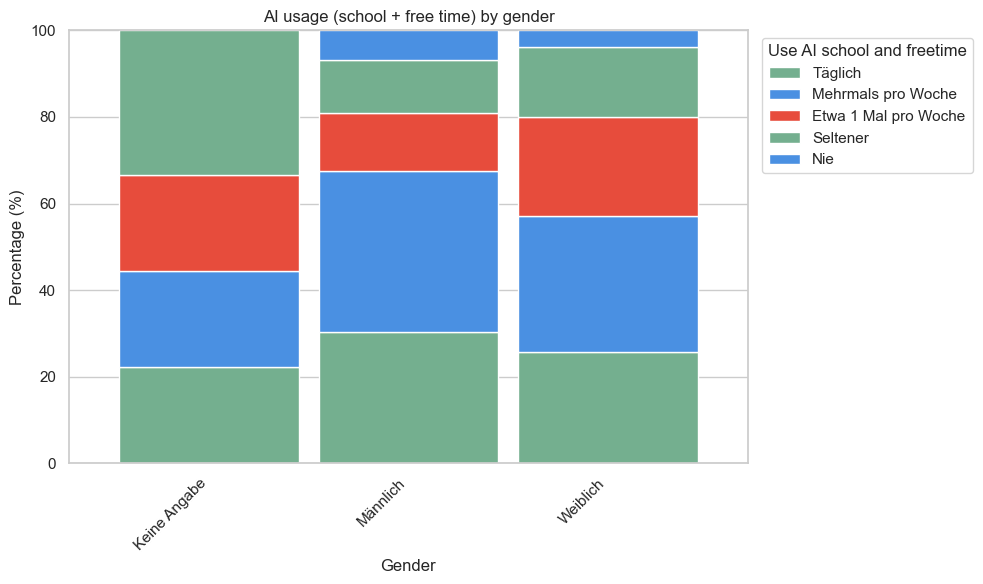


🔍 Chi²-Test for Gender x Usefullness AI: χ²=16.546, df=6, p=0.0111
➡️ Significant at α=0.05

📊 Usefullness AI – distribution of Gender (each Gender sums to 100%)
Counts:
 Usefullness AI  Sehr nützlich  Ziemlich nützlich  Teils/teils  Wenig nützlich
Gender                                                                       
Keine Angabe                3                  1            4               1
Männlich                   37                 31           14               1
Weiblich                   25                 41           33               2

Percent:
 Usefullness AI  Sehr nützlich  Ziemlich nützlich  Teils/teils  Wenig nützlich
Gender                                                                       
Keine Angabe             33.3               11.1         44.4            11.1
Männlich                 44.6               37.3         16.9             1.2
Weiblich                 24.8               40.6         32.7             2.0


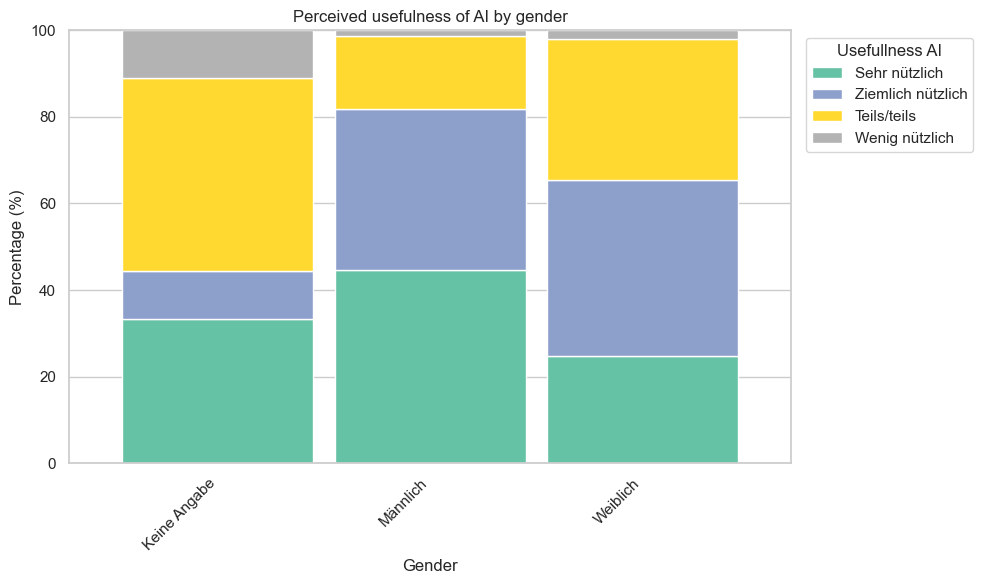


🔍 Chi²-Test for Gender x Most used subjects: χ²=29.275, df=28, p=0.3987
➡️ Not significant

📊 Most used subjects – distribution of Gender (each Gender sums to 100%)
Counts:
 Most used subjects  Berufsorientierung  Biologie  Chemie  Deutsch  Englisch  \
Gender                                                                        
Keine Angabe                         0         0       1        2         0   
Männlich                             1        12      14       28        11   
Weiblich                             2        24      18       28        18   

Most used subjects  Französisch  Geografie  Geschichte  Informatik  Kochen  \
Gender                                                                       
Keine Angabe                  2          3           2           0       0   
Männlich                     22         17          33           8       0   
Weiblich                     29         26          47           1       1   

Most used subjects  Mathematik  Musik 

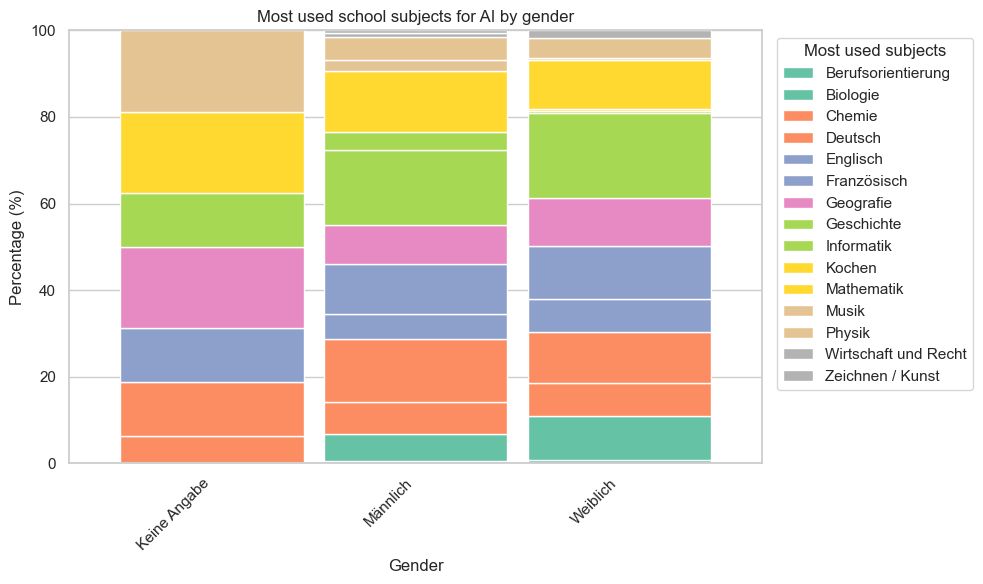


🔍 Chi²-Test for Gender x Help of AI: χ²=19.983, df=6, p=0.0028
➡️ Significant at α=0.05

📊 Help of AI – distribution of Gender (each Gender sums to 100%)
Counts:
 Help of AI    Sehr gut  Eher gut  Neutral  Eher schlecht
Gender                                                  
Keine Angabe         1         2        1              3
Männlich            19        38       19              3
Weiblich            12        49       29              6

Percent:
 Help of AI    Sehr gut  Eher gut  Neutral  Eher schlecht
Gender                                                  
Keine Angabe      14.3      28.6     14.3           42.9
Männlich          24.1      48.1     24.1            3.8
Weiblich          12.5      51.0     30.2            6.2


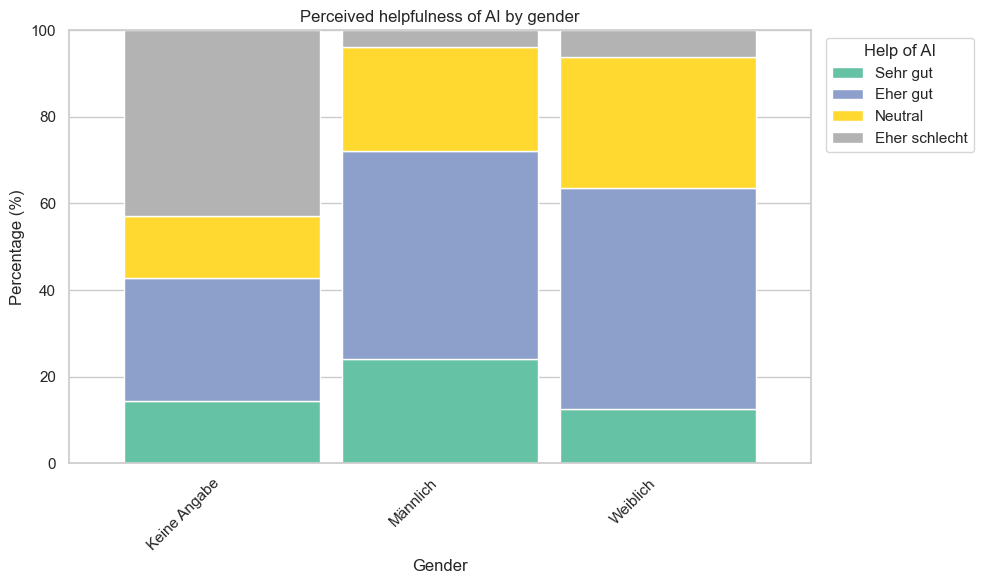


🔍 Chi²-Test for Age x Use AI school and freetime: χ²=88.946, df=24, p=0.0000
➡️ Significant at α=0.05

📊 Use AI school and freetime – distribution of Age (each Age sums to 100%)
Counts:
 Use AI school and freetime  Täglich  Mehrmals pro Woche  Etwa 1 Mal pro Woche  \
Age                                                                             
13                                2                   7                    14   
14                                1                  12                    14   
15                                9                  11                     3   
16                               10                  14                     4   
17                               21                  15                     0   
18                                9                   5                     3   
19                                4                   4                     0   

Use AI school and freetime  Seltener  Nie  
Age                                   

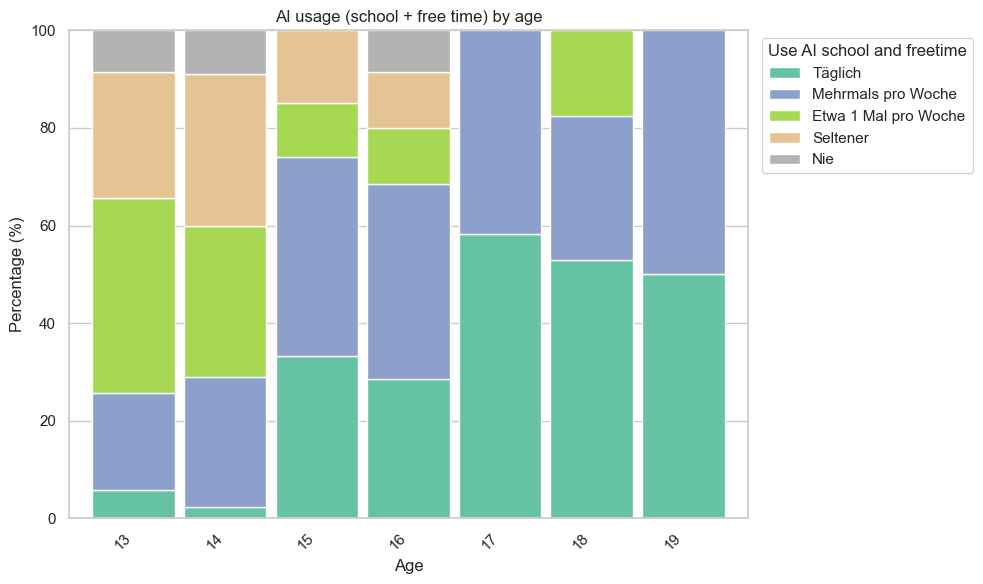


🔍 Chi²-Test for Age x Deal with AI: χ²=35.939, df=24, p=0.0556
➡️ Not significant

📊 Deal with AI – distribution of Age (each Age sums to 100%)
Counts:
 Deal with AI  Sehr gut  Eher gut  Weder gut noch schlecht  Eher schlecht  \
Age                                                                        
13                  10        11                       13              0   
14                   4        19                       18              4   
15                   6        13                        6              2   
16                   9        18                        8              0   
17                   9        21                        6              0   
18                   6        10                        1              0   
19                   3         3                        1              1   

Deal with AI  Schlecht  
Age                     
13                   1  
14                   0  
15                   0  
16                   0  
17         

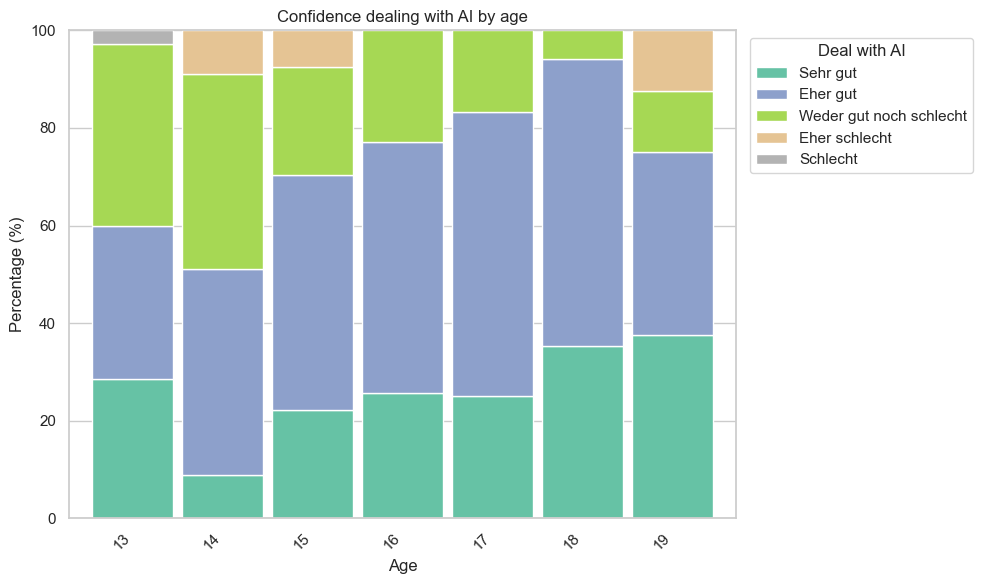


🔍 Chi²-Test for Age x Understanding AI: χ²=27.635, df=24, p=0.2757
➡️ Not significant

📊 Understanding AI – distribution of Age (each Age sums to 100%)
Counts:
 Understanding AI  Sehr gut  Eher gut  Weder gut noch schlecht  Eher wenig  \
Age                                                                         
13                       4         7                       17           6   
14                       3        18                       18           5   
15                       2         6                       11           7   
16                       2        16                       13           4   
17                       4         6                       15           7   
18                       3         3                       10           1   
19                       0         2                        4           2   

Understanding AI  Gar nicht  
Age                          
13                        1  
14                        1  
15                      

C:\Users\tills\AppData\Local\Temp\ipykernel_31024\1460541674.py:100: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\tills\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


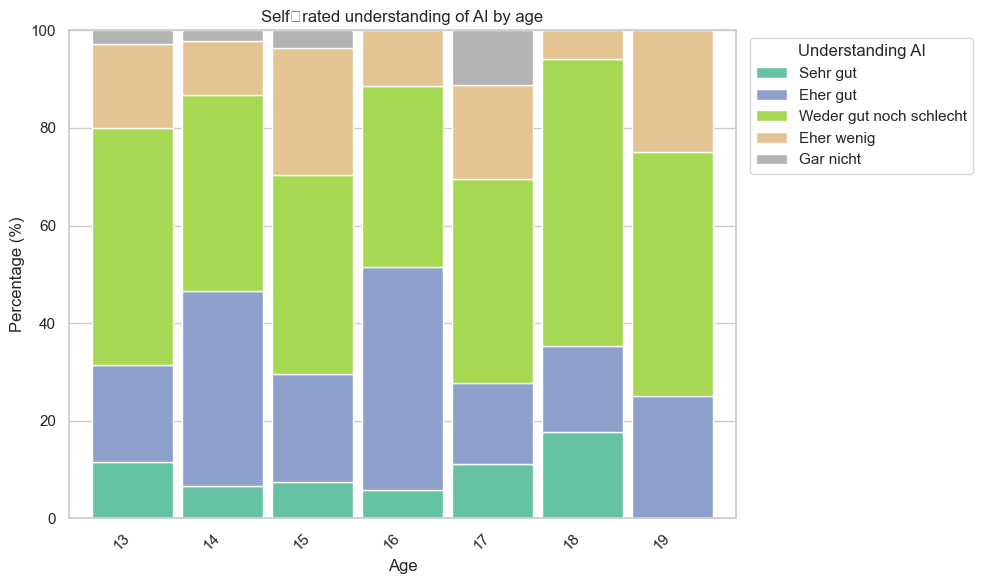


🔍 Chi²-Test for Age x Concerns AI: χ²=31.522, df=12, p=0.0016
➡️ Significant at α=0.05

📊 Concerns AI – distribution of Age (each Age sums to 100%)
Counts:
 Concerns AI  Ja  Nein  Ich habe darüber noch nie nachgedacht.
Age                                                          
13            6    11                                      18
14           22    10                                      13
15            9    10                                       8
16           14    15                                       6
17           17    17                                       2
18            6     8                                       3
19            5     3                                       0

Percent:
 Concerns AI    Ja  Nein  Ich habe darüber noch nie nachgedacht.
Age                                                            
13           17.1  31.4                                    51.4
14           48.9  22.2                                    28.9
15           33.3

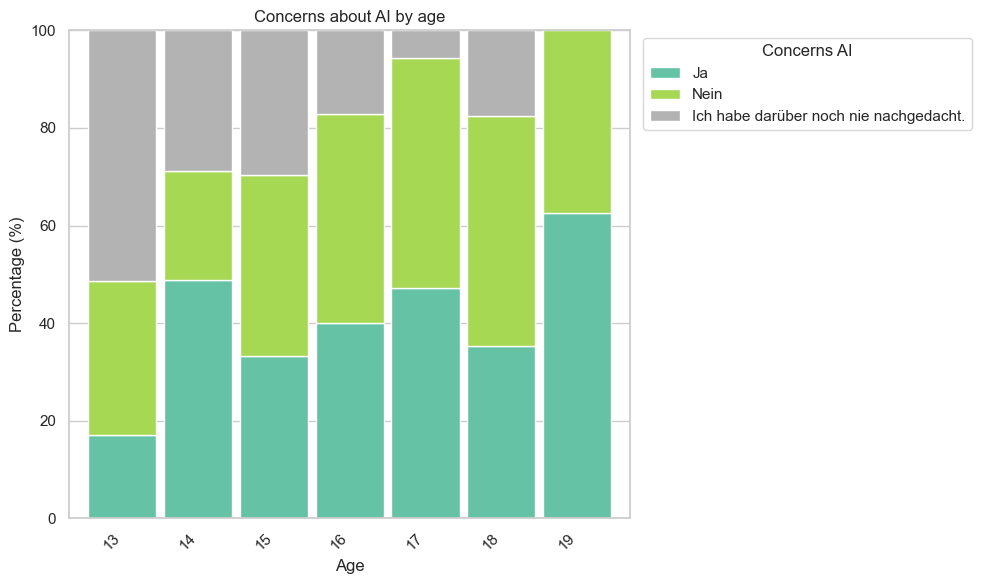


🔍 Chi²-Test for Age x Help of AI: χ²=23.114, df=18, p=0.1863
➡️ Not significant

📊 Help of AI – distribution of Age (each Age sums to 100%)
Counts:
 Help of AI  Sehr gut  Eher gut  Neutral  Eher schlecht
Age                                                   
13                 6        11       10              1
14                 2        15       15              5
15                 7        16        2              1
16                 6        15       10              2
17                 7        20        5              2
18                 2         8        6              0
19                 2         4        1              1

Percent:
 Help of AI  Sehr gut  Eher gut  Neutral  Eher schlecht
Age                                                   
13              21.4      39.3     35.7            3.6
14               5.4      40.5     40.5           13.5
15              26.9      61.5      7.7            3.8
16              18.2      45.5     30.3            6.1
17            

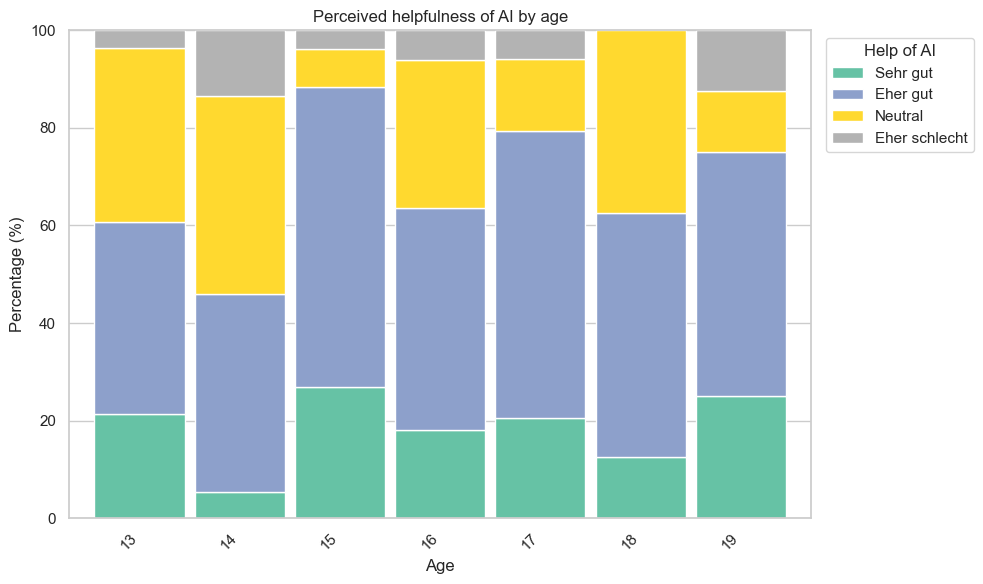


🔍 Chi²-Test for Age x True_False_Score: χ²=63.122, df=36, p=0.0034
➡️ Significant at α=0.05

📊 True_False_Score – distribution of Age (each Age sums to 100%)
Counts:
 True_False_Score  0  1   2  3   4   5  6
Age                                     
13                4  8  10  6   3   3  1
14                2  8   5  7  10   6  7
15                2  1   6  3   6   4  5
16                0  0   3  7   8   9  8
17                1  1   2  6   9  12  5
18                0  0   1  3   6   3  4
19                0  0   0  2   0   4  2

Percent:
 True_False_Score     0     1     2     3     4     5     6
Age                                                       
13                11.4  22.9  28.6  17.1   8.6   8.6   2.9
14                 4.4  17.8  11.1  15.6  22.2  13.3  15.6
15                 7.4   3.7  22.2  11.1  22.2  14.8  18.5
16                 0.0   0.0   8.6  20.0  22.9  25.7  22.9
17                 2.8   2.8   5.6  16.7  25.0  33.3  13.9
18                 0.0   0.0   5.9  17.

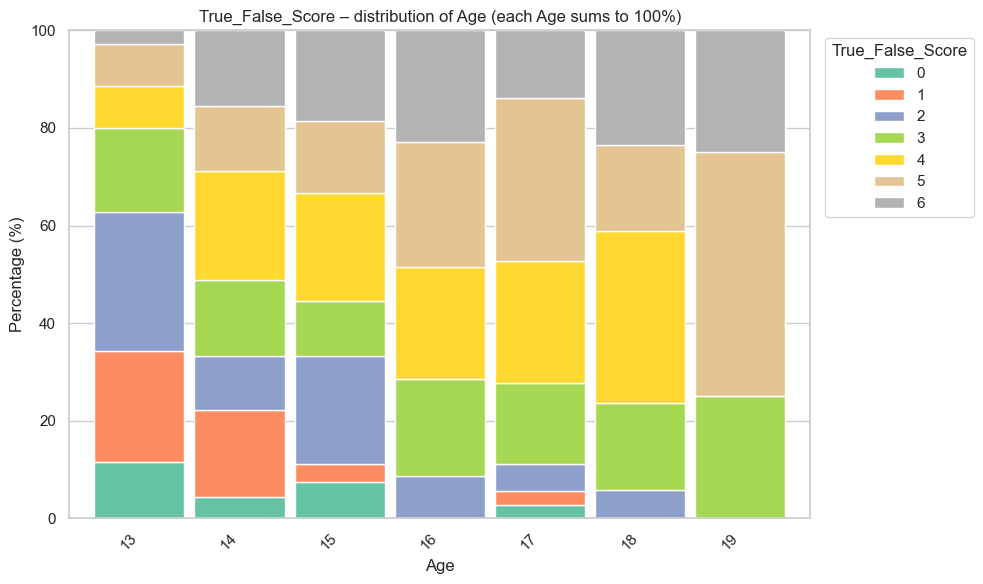


🔍 Chi²-Test for Age x Internet Understanding (Grouped): χ²=82.259, df=24, p=0.0000
➡️ Significant at α=0.05

📊 Internet Understanding (Grouped) – distribution of Age (each Age sums to 100%)
Counts:
 Internet Understanding (Grouped)  Schlechtes Verständnis  \
Age                                                        
13                                                     8   
14                                                    18   
15                                                     6   
16                                                    10   
17                                                     8   
18                                                     3   
19                                                     0   

Internet Understanding (Grouped)  Mittelmässiges Verständnis  \
Age                                                            
13                                                         4   
14                                                        13   
15 

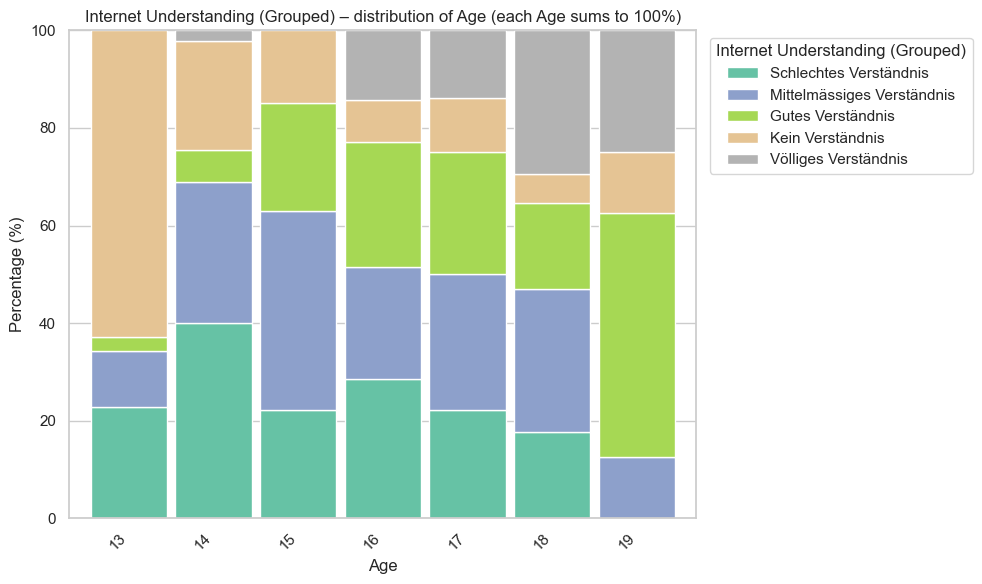


🔍 Chi²-Test for Hours per week for school x Frequency of use education: χ²=13.560, df=8, p=0.0940
➡️ Not significant

📊 Frequency of use education – distribution of Hours per week for school (each Hours per week for school sums to 100%)
Counts:
 Frequency of use education    Nie  Selten  Manchmal  Oft  Sehr oft
Hours per week for school                                         
0-1 Stunde pro Woche            3       8         7   11         4
2-5 Stunden pro Woche           5      25        41   19        17
Mehr als 5 Stunden pro Woche    3       5        16   15        14

Percent:
 Frequency of use education    Nie  Selten  Manchmal   Oft  Sehr oft
Hours per week for school                                          
0-1 Stunde pro Woche          9.1    24.2      21.2  33.3      12.1
2-5 Stunden pro Woche         4.7    23.4      38.3  17.8      15.9
Mehr als 5 Stunden pro Woche  5.7     9.4      30.2  28.3      26.4


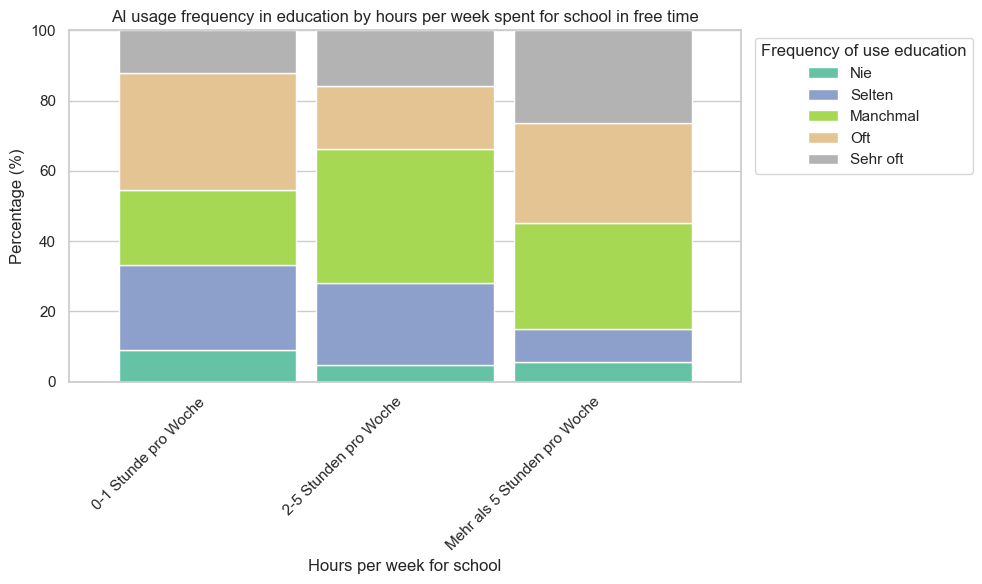


🔍 Chi²-Test for Preferred Subjects x Most used subjects: χ²=263.284, df=238, p=0.1250
➡️ Not significant

📊 Most used subjects – distribution of Preferred Subjects (each Preferred Subjects sums to 100%)
Counts:
 Most used subjects       Berufsorientierung  Biologie  Chemie  Deutsch  \
Preferred Subjects                                                       
Biologie                                  0        12      13        9   
Chemie                                    0         6       1        3   
Deutsch                                   0         3       2        4   
Englisch                                  0        11       8       19   
Französisch                               0         3       2        4   
Geografie                                 0         5       6        6   
Geschichte                                0        10      10       12   
Handarbeit / Werken                       1         1       1        4   
Informatik                                0    

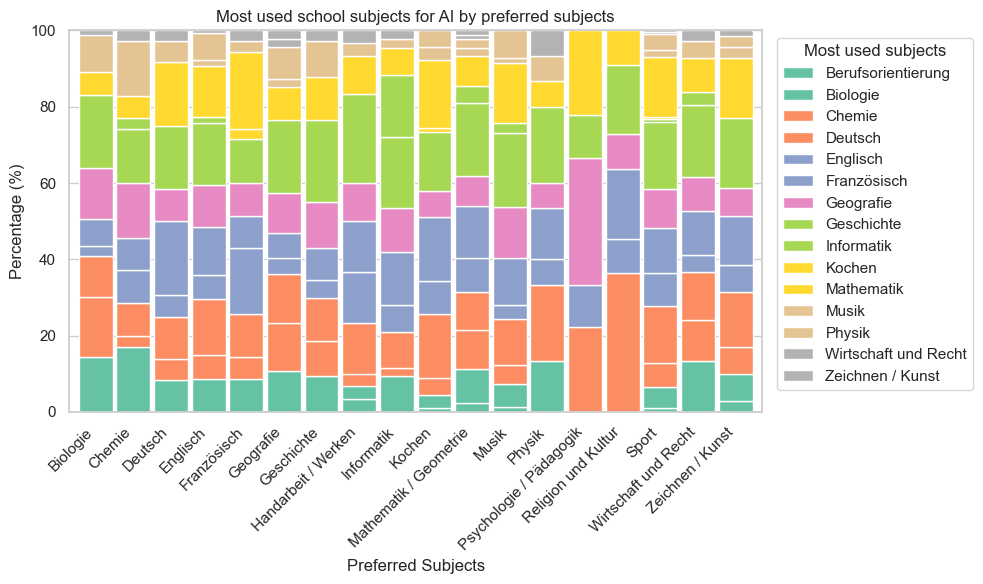


🔍 Chi²-Test for Least preferred Subjects x Most used subjects: χ²=243.312, df=224, p=0.1791
➡️ Not significant

📊 Most used subjects – distribution of Least preferred Subjects (each Least preferred Subjects sums to 100%)
Counts:
 Most used subjects        Berufsorientierung  Biologie  Chemie  Deutsch  \
Least preferred Subjects                                                  
Biologie                                   1         7       6       11   
Chemie                                     0         6       6        9   
Deutsch                                    0         7       2       21   
Englisch                                   0         4       2        8   
Französisch                                1        16      15       29   
Geografie                                  1         2       3       11   
Geschichte                                 0         4       7        8   
Handarbeit / Werken                        0         2       1        2   
Informatik         

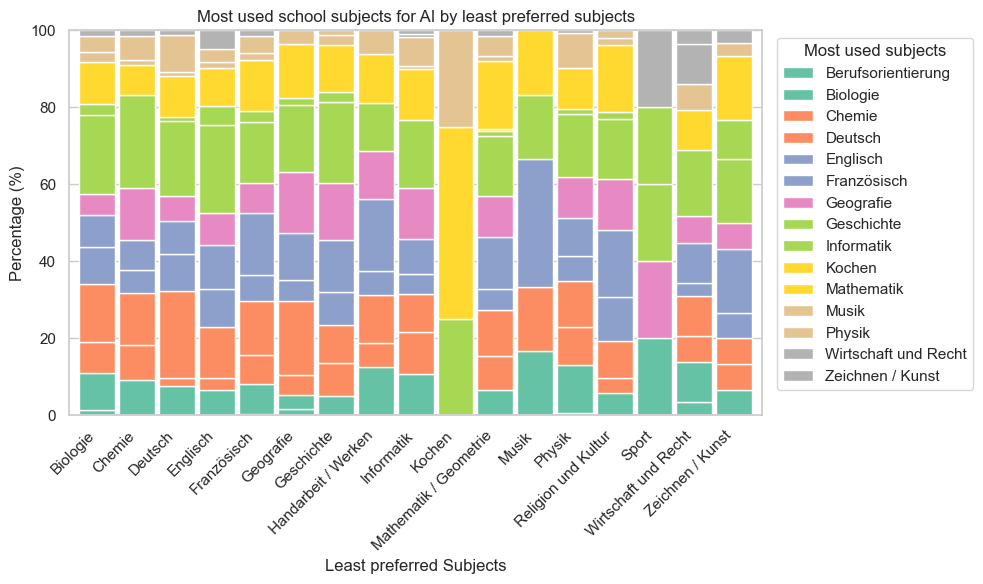

In [3]:
import re
from scipy.stats import chi2_contingency

# --- Helper: robust split für Multi-Choice (lässt Listen unverändert) ---
_split_pattern = re.compile(r"\s*[;,]\s*")

def _to_list(x):
    if isinstance(x, list):
        return x
    if pd.isna(x):
        return []
    return [s.strip() for s in _split_pattern.split(str(x)) if s.strip()]

def build_crosstab(df_in, demo, question, demo_is_multi=False, q_is_multi=False):
    # nur die zwei Spalten, gemeinsame Dropna
    tmp = df_in[[demo, question]].dropna(subset=[demo, question]).copy()

    # Multi-Choice spaltenweise vorbereiten
    if q_is_multi:
        tmp[question] = tmp[question].apply(_to_list)
        tmp = tmp.explode(question)
    else:
        tmp[question] = tmp[question].astype(str).str.strip()

    if demo_is_multi:
        tmp[demo] = tmp[demo].apply(_to_list)
        tmp = tmp.explode(demo)
    else:
        tmp[demo] = tmp[demo].astype(str).str.strip()

    # nach dem Explode leere Einträge filtern
    tmp = tmp[(tmp[demo] != "") & (tmp[question] != "")]
    if tmp.empty:
        return None, None

    ct = pd.crosstab(tmp[demo], tmp[question])

    # Null-Spalten/-Zeilen entfernen (wichtig für Chi²)
    ct = ct.loc[ct.sum(axis=1) > 0, ct.sum(axis=0) > 0]
    if ct.empty:
        return None, None

    return ct, tmp

# --- Main loop (ersetzt deinen Join/ct-Teil) ---
for demo, question_list in comparison_pairs_by_demo.items():
    for question in question_list:
        try:
            d_is_multi = demo in {"Preferred Subjects", "Least preferred Subjects", "Most used subjects"}
            q_is_multi = question in multiple_choice_questions

            ct, _ = build_crosstab(df, demo, question, d_is_multi, q_is_multi)
            if ct is None:
                print(f"⚠️ No overlapping data for '{question}' x '{demo}'. Skipping.")
                continue

            # Reihenfolge (deine vorhandene Logik unverändert)
            if question in question_orders:
                col_order = [v for v in question_orders[question] if v in ct.columns]
                ct = ct[col_order + [c for c in ct.columns if c not in col_order]]
            if demo in question_orders:
                row_order = [v for v in question_orders[demo] if v in ct.index]
                ct = ct.reindex(row_order + [r for r in ct.index if r not in row_order])

            # 100%-Normierung
            ct_percent = (ct.div(ct.sum(axis=1), axis=0) * 100).fillna(0)

            # Chi²: nur wenn sinnvoll (≥2x2), sonst überspringen
            if ct.shape[0] >= 2 and ct.shape[1] >= 2:
                try:
                    chi2, p, dof, _ = chi2_contingency(ct)
                    print(f"\n🔍 Chi²-Test for {demo} x {question}: χ²={chi2:.3f}, df={dof}, p={p:.4f}")
                    print("➡️ Significant at α=0.05" if p < 0.05 else "➡️ Not significant")
                except Exception as e:
                    print(f"ℹ️ Chi² skipped ({e})")

            # Tabellarische Ausgabe
            print(f"\n📊 {question} – distribution of {demo} (each {demo} sums to 100%)")
            print("Counts:\n", ct)
            print("\nPercent:\n", ct_percent.round(1))

            # Plot (deine Farben/Title-Map weiter nutzbar)
            title_and_colors = cross_tab_titles_and_colors.get(
                (demo, question),
                [f"{question} – distribution of {demo} (each {demo} sums to 100%)"]
            )
            plot_title = title_and_colors[0]
            if len(title_and_colors) > 1:
                colors = title_and_colors[1:]
                ax = ct_percent.plot(kind="bar", stacked=True, figsize=(10, 6), color=colors, width=0.9)
            else:
                ax = ct_percent.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="Set2", width=0.9)

            ax.set_title(plot_title)
            ax.set_ylabel("Percentage (%)")
            ax.set_xlabel(demo)
            ax.set_ylim(0, 100)
            plt.xticks(rotation=45, ha="right")
            plt.legend(title=question, bbox_to_anchor=(1.01, 1), loc="upper left")
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"❌ Failed for {question} x {demo}: {e}")


In [ ]:
# ------ description -------

# --- Helper: Prepare column (explode if multiple choice) ---
def prepare_column(df_in, col):
    """Return cleaned Series for a column, exploded if multiple choice."""
    if col in multiple_choice_questions:
        tmp = (
            df_in[[col]]
            .dropna()
            .assign(**{col: df_in[col].astype(str).str.split(",")})
            .explode(col)
        )
        tmp[col] = tmp[col].astype(str).str.strip()
        tmp = tmp[tmp[col] != ""]
        return tmp
    else:
        tmp = df_in[[col]].dropna()
        tmp[col] = tmp[col].astype(str).str.strip()
        tmp = tmp[tmp[col] != ""]
        return tmp

# --- Main loop: stacked 100% bars with significance tests ---
for demo, question_list in comparison_pairs_by_demo.items():
    for question in question_list:
        try:
            q_is_multi = question in multiple_choice_questions
            d_is_multi = demo in multiple_choice_questions

            if q_is_multi and d_is_multi:
                # both multiple-choice → split both, explode both from the SAME slice
                tmp = df[[demo, question]].dropna().copy()
                tmp[demo] = tmp[demo].astype(str).str.split(",")
                tmp[question] = tmp[question].astype(str).str.split(",")
                data = tmp.explode(demo).explode(question)
                data[demo] = data[demo].astype(str).str.strip()
                data[question] = data[question].astype(str).str.strip()
                data = data[(data[demo] != "") & (data[question] != "")]
            elif q_is_multi and not d_is_multi:
                # question multiple, demo single
                tmp = df[[demo, question]].dropna().copy()
                tmp[question] = tmp[question].astype(str).str.split(",")
                data = tmp.explode(question)
                data[demo] = data[demo].astype(str).str.strip()
                data[question] = data[question].astype(str).str.strip()
                data = data[(data[demo] != "") & (data[question] != "")]
            elif not q_is_multi and d_is_multi:
                # demo multiple, question single
                tmp = df[[demo, question]].dropna().copy()
                tmp[demo] = tmp[demo].astype(str).str.split(",")
                data = tmp.explode(demo)
                data[demo] = data[demo].astype(str).str.strip()
                data[question] = data[question].astype(str).str.strip()
                data = data[(data[demo] != "") & (data[question] != "")]
            else:
                # both single
                data = df[[demo, question]].dropna().copy()
                data[demo] = data[demo].astype(str).str.strip()
                data[question] = data[question].astype(str).str.strip()
                data = data[(data[demo] != "") & (data[question] != "")]
            if data.empty:
                print(f"⚠️ No overlapping data for '{question}' x '{demo}'. Skipping.")
                continue
            
            # Crosstab: rows = demo categories, cols = question answers
            ct = pd.crosstab(data[demo], data[question])

            # Falls (selten) doppelte Spalten-/Indexnamen existieren → zusammenfalten
            if not ct.columns.is_unique:
                ct = ct.T.groupby(level=0).sum().T
            if not ct.index.is_unique:
                ct = ct.groupby(level=0).sum()        

            # Crosstab: rows = demo categories (X-axis), cols = question answers (stack colors)
            ct = pd.crosstab(data[demo], data[question])

            # Order columns (answers)
            if question in question_orders:
                col_order = [v for v in question_orders[question] if v in ct.columns]
                remaining_cols = [v for v in ct.columns if v not in col_order]
                ct = ct[col_order + remaining_cols]
            else:
                try:
                    _ = pd.to_numeric(ct.columns)
                    ct = ct[sorted(ct.columns, key=lambda x: float(x))]
                except Exception:
                    pass

            # Order rows (demo categories)
            if demo in question_orders:
                row_order = [v for v in question_orders[demo] if v in ct.index]
                remaining_rows = [v for v in ct.index if v not in row_order]
                ct = ct.reindex(row_order + remaining_rows)
            else:
                try:
                    ct.index = pd.to_numeric(ct.index)
                    ct = ct.sort_index()
                except Exception:
                    pass

            # Normalize so each demo category sums to 100%
            ct_percent = ct.div(ct.sum(axis=1), axis=0) * 100

            # Chi² significance test
            chi2, p, dof, expected = chi2_contingency(ct)
            print(f"\n🔍 Chi²-Test for {demo} x {question}")
            print(f"Chi² = {chi2:.3f}, df = {dof}, p-value = {p:.4f}")
            if p < 0.05:
                print("➡️ Significant at α = 0.05")
            else:
                print("➡️ Not significant")

            # Tabular output
            print(f"\n📊 {question} – distribution of {demo} (each {demo} sums to 100%)")
            print("Counts:")
            print(ct)
            print("\nPercent:")
            print(ct_percent.round(1))

            # Plot
            title_and_colors = cross_tab_titles_and_colors.get(
                (demo, question),
                [f"{question} – distribution of {demo} (each {demo} sums to 100%)"]
            )
            plot_title = title_and_colors[0]

            if len(title_and_colors) > 1:
                colors = title_and_colors[1:]
                ax = ct_percent.plot(
                    kind="bar",
                    stacked=True,
                    figsize=(10, 6),
                    color=colors,
                    width=0.9
                )
            else:
                ax = ct_percent.plot(
                    kind="bar",
                    stacked=True,
                    figsize=(10, 6),
                    colormap="Set2",
                    width=0.9
                )

            ax.set_title(plot_title)
            ax.set_ylabel("Percentage (%)")
            ax.set_xlabel(demo)
            ax.set_ylim(0, 100)
            plt.xticks(rotation=45, ha="right")
            plt.legend(title=question, bbox_to_anchor=(1.01, 1), loc="upper left")
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"❌ Failed for {question} x {demo}: {e}")
